<a href="https://colab.research.google.com/github/SUYAMBULAKSHMI-VENKATESAN/DAMAKA/blob/main/Iris_Segmentation_Using_SSL_CNN_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import torch
import torchvision.transforms as transforms
from glob import glob
from PIL import Image
import numpy as np
import cv2
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [7]:
from google.colab import drive
drive.mount('/content/drive')  # ONLY mount to /content/drive

# Set path to your dataset folder
DATASET_DIR = "/content/drive/MyDrive/ConsolidatedImages"
PREPROCESSED_DIR = "/content/drive/MyDrive/Pre_Image"

# Create output folder if it doesn't exist
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Optional test
import os
files = os.listdir(DATASET_DIR)
print("Total files:", len(files))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total files: 2251


In [8]:
def preprocess_image(image):
    # Step 1: Gaussian Blur
    blurred = cv2.GaussianBlur(image, (3, 3), 1.0)

    # Step 2: CLAHE
    clahe = cv2.createCLAHE(clipLimit=3.5, tileGridSize=(8, 8))
    clahe_result = clahe.apply(blurred)

    # Step 3: Brightness & Contrast Boosting
    scaled = cv2.convertScaleAbs(clahe_result, alpha=1.75, beta=30)

    # Ensure within 0–255
    scaled = np.clip(scaled, 0, 255).astype(np.uint8)

    return scaled

In [9]:
image_paths = sorted(glob(os.path.join(DATASET_DIR, "*.bmp")))
stat_table = []

print(f"Found {len(image_paths)} images in the dataset.")

for path in tqdm(image_paths, desc="Preprocessing Images"):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    processed = preprocess_image(img)

    # Save output
    filename = os.path.basename(path)
    out_path = os.path.join(PREPROCESSED_DIR, filename)
    cv2.imwrite(out_path, processed)

    # Collect statistics
    mean_intensity = round(np.mean(processed), 2)
    std_dev = round(np.std(processed), 2)
    pixel_count = processed.size

    stat_table.append([filename, mean_intensity, std_dev, pixel_count])


Found 2251 images in the dataset.


Preprocessing Images: 100%|██████████| 2251/2251 [00:49<00:00, 45.80it/s]


In [10]:
import os
files_2 = os.listdir(PREPROCESSED_DIR)
print("Total files:", len(files_2))

Total files: 2251


In [11]:
# Display the table
headers = ["Image", "Mean Intensity", "Std Dev", "Pixel Count"]
print(tabulate(stat_table[:10], headers=headers, tablefmt="grid"))  # show first 10

# Save full table as CSV
df = pd.DataFrame(stat_table, columns=headers)
df.to_csv("/content/drive/MyDrive/preprocessing_summary.csv", index=False)

# Compute average stats across the dataset
means = [row[1] for row in stat_table]
stds = [row[2] for row in stat_table]
pixels = [row[3] for row in stat_table]

print("\n📊 Average Stats Across All Images:")
print(f"Average Mean Intensity : {np.mean(means):.2f}")
print(f"Average Std Deviation  : {np.mean(stds):.2f}")
print(f"Average Pixel Count    : {np.mean(pixels):.0f}")


+---------------------------------+------------------+-----------+---------------+
| Image                           |   Mean Intensity |   Std Dev |   Pixel Count |
+=================================+==================+===========+===============+
| 01_L_001_ConsolidatedImages.bmp |           217.85 |     65.9  |         76800 |
+---------------------------------+------------------+-----------+---------------+
| 01_L_002_ConsolidatedImages.bmp |           202.16 |     78.39 |         76800 |
+---------------------------------+------------------+-----------+---------------+
| 01_L_003_ConsolidatedImages.bmp |           216.55 |     56.72 |         76800 |
+---------------------------------+------------------+-----------+---------------+
| 01_L_004_ConsolidatedImages.bmp |           201.2  |     73.8  |         76800 |
+---------------------------------+------------------+-----------+---------------+
| 01_L_005_ConsolidatedImages.bmp |           216.84 |     64.99 |         76800 |
+---

In [12]:
pip install torch torchvision albumentations opencv-python scikit-image matplotlib segmentation-models-pytorch timm einops


In [13]:
!pip install pytorch-lightning torchvision


In [14]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import os
import numpy as np
from PIL import Image
from tqdm import tqdm



class SimCLRDataset(Dataset):
    def __init__(self, image_dir, transform):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.bmp')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # grayscale
        image = image.convert("RGB")  # now has 3 channels (duplicate gray to RGB)
        xi = self.transform(image)
        xj = self.transform(image)
        return xi, xj




simclr_transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomResizedCrop(128, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.GaussianBlur(3)], p=0.5),
    T.ToTensor()
])

preprocessed_path = "/content/drive/MyDrive/Pre_Image"

simclr_dataset = SimCLRDataset(preprocessed_path, simclr_transform)
simclr_loader = DataLoader(simclr_dataset, batch_size=64, shuffle=True, drop_last=True)


In [15]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = base_model
        self.encoder.fc = nn.Identity()  # remove original FC layer
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        z = F.normalize(z, dim=1)  # ⬅️ normalize for contrastive similarity
        return z


In [16]:
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # [2N, D]

    similarity = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2N, 2N]

    # Remove self-similarity
    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -1e9)

    positives = torch.cat([torch.arange(N, 2*N), torch.arange(0, N)]).to(z.device)
    labels = positives

    logits = similarity / temperature
    loss = F.cross_entropy(logits, labels)
    return loss


In [17]:
resnet = models.resnet18(weights=None) # or use pretrained="imagenet"
model = SimCLR(resnet).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


EPOCHS = 50
torch.autograd.set_detect_anomaly(True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xi, xj in tqdm(simclr_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        xi, xj = xi.to(device), xj.to(device)
        zi = model(xi)
        zj = model(xj)

        loss = nt_xent_loss(zi, zj)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(simclr_loader)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")


Epoch 1/50: 100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


Epoch 1 Loss: 4.1704


Epoch 2/50: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]


Epoch 2 Loss: 3.6426


Epoch 3/50: 100%|██████████| 35/35 [00:30<00:00,  1.14it/s]


Epoch 3 Loss: 3.5081


Epoch 4/50: 100%|██████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch 4 Loss: 3.4031


Epoch 5/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 5 Loss: 3.3124


Epoch 6/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 6 Loss: 3.2408


Epoch 7/50: 100%|██████████| 35/35 [00:30<00:00,  1.15it/s]


Epoch 7 Loss: 3.1855


Epoch 8/50: 100%|██████████| 35/35 [00:30<00:00,  1.15it/s]


Epoch 8 Loss: 3.1487


Epoch 9/50: 100%|██████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch 9 Loss: 3.1206


Epoch 10/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 10 Loss: 3.1099


Epoch 11/50: 100%|██████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch 11 Loss: 3.0920


Epoch 12/50: 100%|██████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch 12 Loss: 3.0804


Epoch 13/50: 100%|██████████| 35/35 [00:30<00:00,  1.16it/s]


Epoch 13 Loss: 3.0635


Epoch 14/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 14 Loss: 3.0559


Epoch 15/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 15 Loss: 3.0477


Epoch 16/50: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 16 Loss: 3.0410


Epoch 17/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 17 Loss: 3.0323


Epoch 18/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 18 Loss: 3.0293


Epoch 19/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 19 Loss: 3.0238


Epoch 20/50: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 20 Loss: 3.0176


Epoch 21/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 21 Loss: 3.0119


Epoch 22/50: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 22 Loss: 3.0053


Epoch 23/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 23 Loss: 3.0072


Epoch 24/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 24 Loss: 3.0038


Epoch 25/50: 100%|██████████| 35/35 [00:30<00:00,  1.15it/s]


Epoch 25 Loss: 3.0006


Epoch 26/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 26 Loss: 2.9958


Epoch 27/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 27 Loss: 2.9910


Epoch 28/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 28 Loss: 2.9930


Epoch 29/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 29 Loss: 2.9875


Epoch 30/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 30 Loss: 2.9826


Epoch 31/50: 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]


Epoch 31 Loss: 2.9848


Epoch 32/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 32 Loss: 2.9790


Epoch 33/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 33 Loss: 2.9789


Epoch 34/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 34 Loss: 2.9761


Epoch 35/50: 100%|██████████| 35/35 [00:29<00:00,  1.21it/s]


Epoch 35 Loss: 2.9725


Epoch 36/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 36 Loss: 2.9739


Epoch 37/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 37 Loss: 2.9733


Epoch 38/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 38 Loss: 2.9724


Epoch 39/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 39 Loss: 2.9671


Epoch 40/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 40 Loss: 2.9703


Epoch 41/50: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Epoch 41 Loss: 2.9695


Epoch 42/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 42 Loss: 2.9682


Epoch 43/50: 100%|██████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch 43 Loss: 2.9648


Epoch 44/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 44 Loss: 2.9635


Epoch 45/50: 100%|██████████| 35/35 [00:29<00:00,  1.17it/s]


Epoch 45 Loss: 2.9609


Epoch 46/50: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 46 Loss: 2.9614


Epoch 47/50: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Epoch 47 Loss: 2.9612


Epoch 48/50: 100%|██████████| 35/35 [00:29<00:00,  1.18it/s]


Epoch 48 Loss: 2.9607


Epoch 49/50: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 49 Loss: 2.9573


Epoch 50/50: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]

Epoch 50 Loss: 2.9582


In [18]:
torch.save(model.encoder.state_dict(), "/content/drive/MyDrive/simclr_encoder.pth")


In [19]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q --upgrade torchvision

In [20]:
from google.colab import drive
import os
drive.mount('/content/drive')

input_folder = "/content/drive/MyDrive/Pre_Image"
output_folder = "/content/drive/MyDrive/GeneratedMasks_new"
os.makedirs(output_folder, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import torchvision
import torch
from torchvision.transforms import functional as F
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained Mask R-CNN (COCO-trained)
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [22]:
def predict_mask(img_tensor, threshold=0.5):
    with torch.no_grad():
        prediction = model([img_tensor.to(device)])[0]
    masks = prediction['masks']
    scores = prediction['scores']

    if len(masks) == 0:
        return None

    # Filter by confidence
    final_mask = torch.zeros_like(masks[0][0], dtype=torch.uint8)
    for i, score in enumerate(scores):
        if score > threshold:
            mask = masks[i][0] > 0.5
            final_mask = torch.bitwise_or(final_mask, mask.byte())
    return final_mask.cpu().numpy()


In [23]:
from glob import glob
image_paths = sorted(glob(os.path.join(input_folder, "*.bmp")))

for path in tqdm(image_paths, desc="Generating Masks"):
    img = Image.open(path).convert("RGB")
    img_tensor = F.to_tensor(img).to(device)

    mask = predict_mask(img_tensor)

    # If no mask found, skip
    if mask is None:
        continue

    # Save mask
    filename = os.path.splitext(os.path.basename(path))[0] + "_mask.png"
    out_path = os.path.join(output_folder, filename)
    cv2.imwrite(out_path, mask.astype(np.uint8) * 255)


Generating Masks: 100%|██████████| 2251/2251 [05:44<00:00,  6.54it/s]


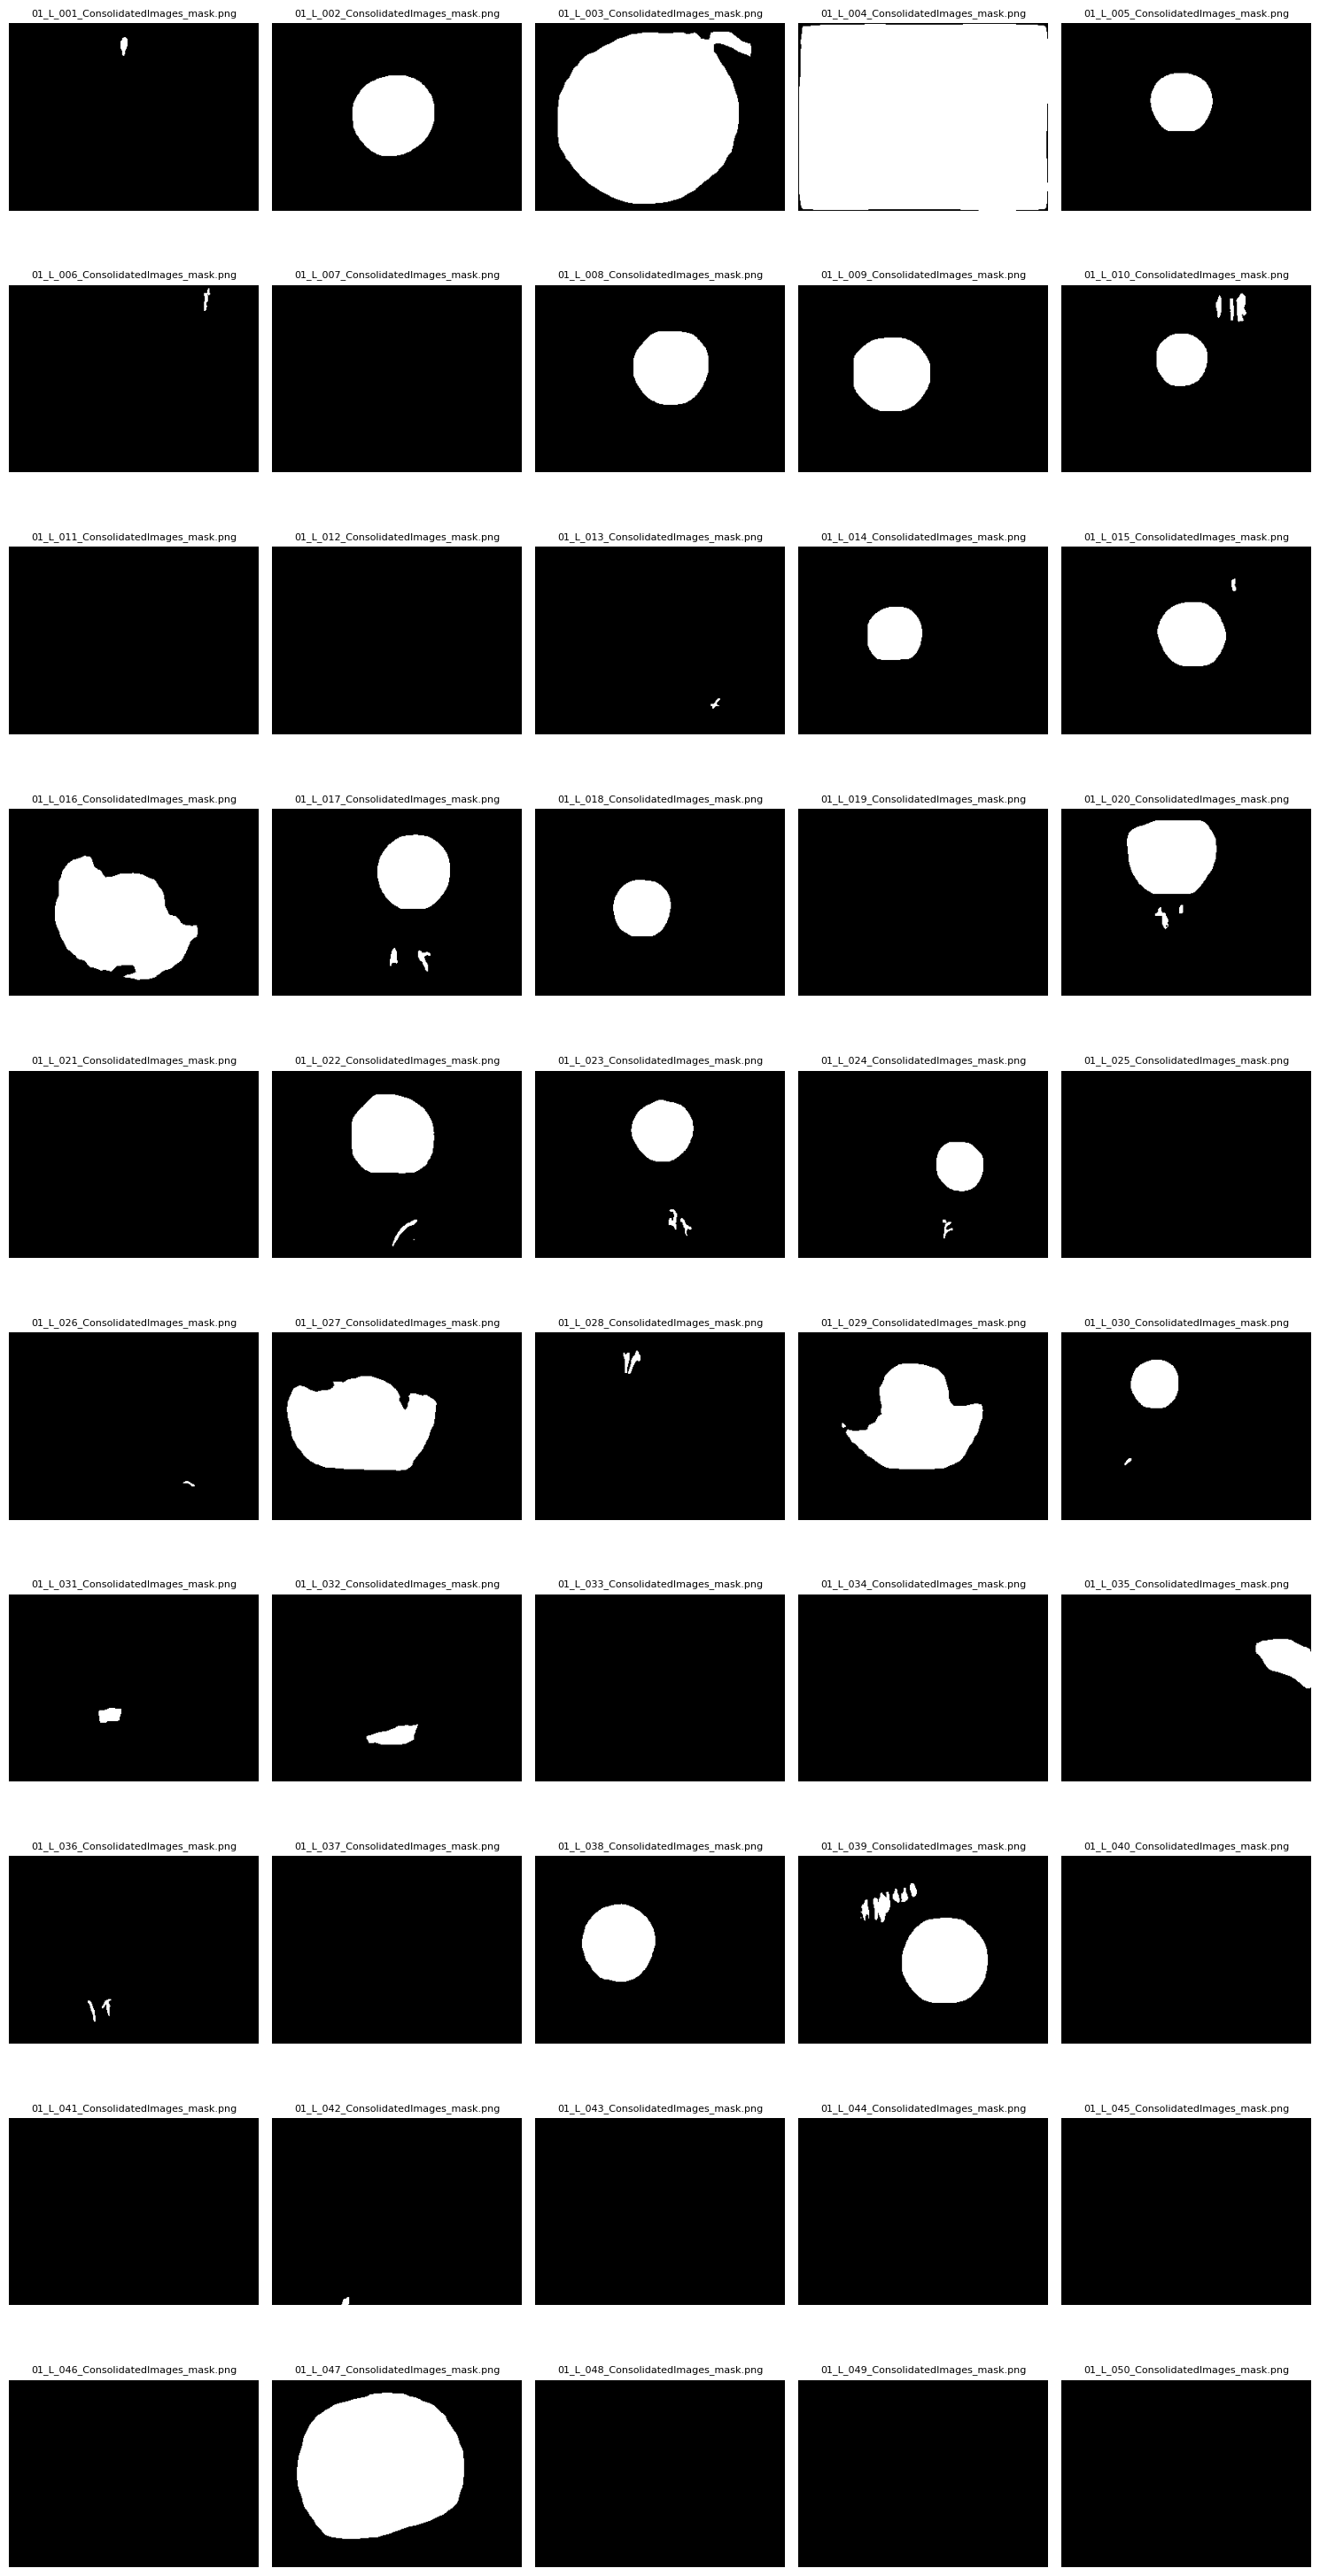

In [24]:
import matplotlib.pyplot as plt
import cv2
import os

# Folder with generated masks
mask_folder = "/content/drive/MyDrive/GeneratedMasks_new"

# List first 50 mask files
mask_files = sorted(os.listdir(mask_folder))[:50]

plt.figure(figsize=(15, 30))
for i, fname in enumerate(mask_files):
    mask_path = os.path.join(mask_folder, fname)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(10, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(fname, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
pip install segmentation-models-pytorch timm einops


In [26]:
import torch
import torch.nn as nn
from torchvision import models
from timm.models.vision_transformer import VisionTransformer
from einops import rearrange

class TransUNet(nn.Module):
    def __init__(self, encoder, img_size=128, patch_size=16, num_classes=1, dim=768):
        super(TransUNet, self).__init__()
        self.encoder = encoder

        # Freeze encoder (optional if using SSL pretrained)
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Transformer (ViT) decoder
        self.vit = VisionTransformer(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=512,  # Output channels from ResNet encoder (last conv block)
            num_classes=0,
            embed_dim=dim,
            depth=6,
            num_heads=8,
            mlp_ratio=4.0,
            qkv_bias=True
        )

        # Decoder / Segmentation head
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.encoder(x)
        x = features[-1]  # use last ResNet conv feature
        B, C, H, W = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.vit(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H // 2, w=W // 2)
        out = self.decoder(x)
        return out


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Projection head used in SimCLR
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(in_dim, 512)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512, out_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# SimCLR model wrapper
class SimCLR(nn.Module):
    def __init__(self, encoder):
        super(SimCLR, self).__init__()
        self.encoder = nn.Sequential(*list(encoder.children())[:-1])  # remove FC layer
        self.projector = ProjectionHead(512)

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.projector(h)
        return z


In [28]:
from torchvision import models
import torch

# Load plain ResNet18
resnet_encoder = models.resnet18(weights=None)

# Load pretrained SimCLR encoder weights and ignore missing fc layer
state_dict = torch.load('/content/drive/MyDrive/simclr_encoder.pth')
resnet_encoder.load_state_dict(state_dict, strict=False)

# Remove final avgpool and fc layers to use it as a feature extractor
modules = list(resnet_encoder.children())[:-2]  # Keep conv layers only
resnet_encoder = torch.nn.Sequential(*modules).to(device)


In [29]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


In [30]:
class IrisSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.bmp')]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        mask_name = image_name.replace(".bmp", "_mask.png")

        img_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Make 3 channels
        mask = (mask > 127).astype(np.float32)  # Binary mask

        if self.transform:
            image = self.transform(image)
        mask = torch.tensor(mask).unsqueeze(0)  # Shape: [1, H, W]

        return image, mask


In [31]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

image_dir = "/content/drive/MyDrive/Pre_Image"
mask_dir = "/content/drive/MyDrive/GeneratedMasks_new"

dataset = IrisSegmentationDataset(image_dir, mask_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [32]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from einops import rearrange

class TransUNet(nn.Module):
    def __init__(self, encoder, num_classes=1, dim=512, num_layers=4, num_heads=8):
        super(TransUNet, self).__init__()
        self.encoder = encoder

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=num_heads,
            dim_feedforward=1024,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        feats = self.encoder(x)               # (B, 512, H, W)
        B, C, H, W = feats.shape

        x = rearrange(feats, 'b c h w -> b (h w) c')  # (B, N, C)
        x = self.transformer(x)                       # (B, N, C)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H, w=W)

        out = self.decoder(x)                         # (B, 1, H, W)
        return out


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransUNet(encoder=resnet_encoder).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Epoch 1/10: 100%|██████████| 141/141 [01:06<00:00,  2.11it/s]


Epoch 1/10 - Loss: 0.1554


Epoch 2/10: 100%|██████████| 141/141 [00:52<00:00,  2.70it/s]


Epoch 2/10 - Loss: 0.1267


Epoch 3/10: 100%|██████████| 141/141 [00:50<00:00,  2.79it/s]


Epoch 3/10 - Loss: 0.1209


Epoch 4/10: 100%|██████████| 141/141 [00:50<00:00,  2.80it/s]


Epoch 4/10 - Loss: 0.1141


Epoch 5/10: 100%|██████████| 141/141 [00:50<00:00,  2.81it/s]


Epoch 5/10 - Loss: 0.1110


Epoch 6/10: 100%|██████████| 141/141 [00:50<00:00,  2.79it/s]


Epoch 6/10 - Loss: 0.1002


Epoch 7/10: 100%|██████████| 141/141 [00:49<00:00,  2.84it/s]


Epoch 7/10 - Loss: 0.0916


Epoch 8/10: 100%|██████████| 141/141 [00:50<00:00,  2.80it/s]


Epoch 8/10 - Loss: 0.0805


Epoch 9/10: 100%|██████████| 141/141 [00:50<00:00,  2.76it/s]


Epoch 9/10 - Loss: 0.0785


Epoch 10/10: 100%|██████████| 141/141 [00:51<00:00,  2.75it/s]

Epoch 10/10 - Loss: 0.0676


In [34]:
torch.save(model.state_dict(), "/content/drive/MyDrive/transunet_iris.pth")


In [35]:
pip install torchmetrics segmentation-models-pytorch


In [36]:
!pip uninstall -y transformers
!pip install transformers==4.36.2


Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


In [37]:
import torch
print(torch.__version__)


2.7.0+cu126


In [38]:
pip install torchmetrics segmentation-models-pytorch


In [39]:
import torch
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy, BinaryJaccardIndex, BinaryF1Score, BinaryPrecision, BinaryRecall
from segmentation_models_pytorch.losses import DiceLoss


In [40]:
dice_loss = DiceLoss(mode='binary')  # from segmentation_models_pytorch
bce_loss = torch.nn.BCEWithLogitsLoss()

def combined_loss(preds, targets):
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)


In [41]:
from torchmetrics.classification import BinaryAccuracy, BinaryJaccardIndex, BinaryF1Score, BinaryPrecision, BinaryRecall

accuracy_metric = BinaryAccuracy().to(device)
iou_metric = BinaryJaccardIndex().to(device)
dice_metric = BinaryF1Score().to(device)
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)


In [42]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    # Reset metrics for each epoch
    accuracy_metric.reset()
    iou_metric.reset()
    dice_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = combined_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update metrics
        probs = torch.sigmoid(preds)
        binary_preds = (probs > 0.5).float()
        accuracy_metric.update(binary_preds, masks.int())
        iou_metric.update(binary_preds, masks.int())
        dice_metric.update(binary_preds, masks.int())
        precision_metric.update(binary_preds, masks.int())
        recall_metric.update(binary_preds, masks.int())

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_metric.compute().item()
    iou = iou_metric.compute().item()
    dice = dice_metric.compute().item()
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f} | Acc: {acc:.4f} | IoU: {iou:.4f} | Dice: {dice:.4f} | Prec: {precision:.4f} | Recall: {recall:.4f}")


Epoch 1/10: 100%|██████████| 141/141 [00:54<00:00,  2.58it/s]


Epoch 1/10 - Loss: 0.2689 | Acc: 0.9649 | IoU: 0.4576 | Dice: 0.6279 | Prec: 0.6211 | Recall: 0.6348


Epoch 2/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 2/10 - Loss: 0.2390 | Acc: 0.9693 | IoU: 0.5081 | Dice: 0.6738 | Prec: 0.6689 | Recall: 0.6788


Epoch 3/10: 100%|██████████| 141/141 [00:54<00:00,  2.57it/s]


Epoch 3/10 - Loss: 0.2058 | Acc: 0.9746 | IoU: 0.5739 | Dice: 0.7293 | Prec: 0.7253 | Recall: 0.7333


Epoch 4/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 4/10 - Loss: 0.1796 | Acc: 0.9787 | IoU: 0.6219 | Dice: 0.7669 | Prec: 0.7825 | Recall: 0.7518


Epoch 5/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 5/10 - Loss: 0.1787 | Acc: 0.9789 | IoU: 0.6287 | Dice: 0.7720 | Prec: 0.7783 | Recall: 0.7658


Epoch 6/10: 100%|██████████| 141/141 [00:54<00:00,  2.60it/s]


Epoch 6/10 - Loss: 0.1505 | Acc: 0.9823 | IoU: 0.6781 | Dice: 0.8082 | Prec: 0.8164 | Recall: 0.8001


Epoch 7/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 7/10 - Loss: 0.1429 | Acc: 0.9838 | IoU: 0.7019 | Dice: 0.8248 | Prec: 0.8346 | Recall: 0.8153


Epoch 8/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 8/10 - Loss: 0.1334 | Acc: 0.9850 | IoU: 0.7177 | Dice: 0.8356 | Prec: 0.8541 | Recall: 0.8179


Epoch 9/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]


Epoch 9/10 - Loss: 0.1255 | Acc: 0.9857 | IoU: 0.7308 | Dice: 0.8445 | Prec: 0.8594 | Recall: 0.8300


Epoch 10/10: 100%|██████████| 141/141 [00:54<00:00,  2.59it/s]

Epoch 10/10 - Loss: 0.1103 | Acc: 0.9873 | IoU: 0.7556 | Dice: 0.8608 | Prec: 0.8828 | Recall: 0.8398
